In [1]:
# Upgrade scikit-learn and install scikeras
!pip install --upgrade scikit-learn scikeras

# Now import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from scikeras.wrappers import KerasRegressor

print("All libraries imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 67.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
All libraries imported successfully!


In [3]:
# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Dataset shape: (500, 450)
           hsi_id         0         1         2         3         4         5  \
0  imagoai_corn_0  0.416181  0.396844  0.408985  0.372865  0.385293  0.365390   
1  imagoai_corn_1  0.415797  0.402956  0.402564  0.396014  0.397192  0.389634   
2  imagoai_corn_2  0.389023  0.371206  0.373098  0.373872  0.361056  0.349709   
3  imagoai_corn_3  0.468837  0.473255  0.462949  0.459335  0.461672  0.459824   
4  imagoai_corn_4  0.483352  0.487274  0.469153  0.487648  0.464026  0.451152   

          6         7         8  ...       439       440       441       442  \
0  0.355226  0.343350  0.344837  ...  0.710280  0.717482  0.715078  0.705379   
1  0.375671  0.363689  0.373883  ...  0.684011  0.697271  0.701995  0.696077   
2  0.333882  0.330841  0.328925  ...  0.683054  0.669286  0.663179  0.676165   
3  0.458194  0.427737  0.415360  ...  0.742782  0.730801  0.736787  0.730044   
4  0.458229  0.440782  0.426193  ...  0.770227  0.773013  0.761431  0.763488   

      

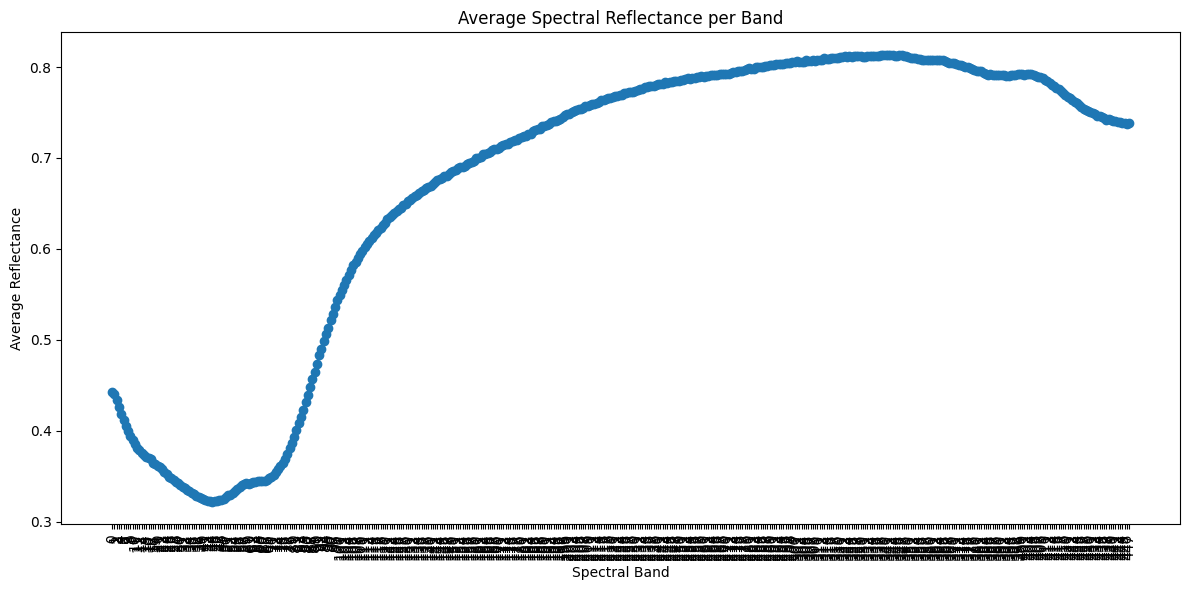

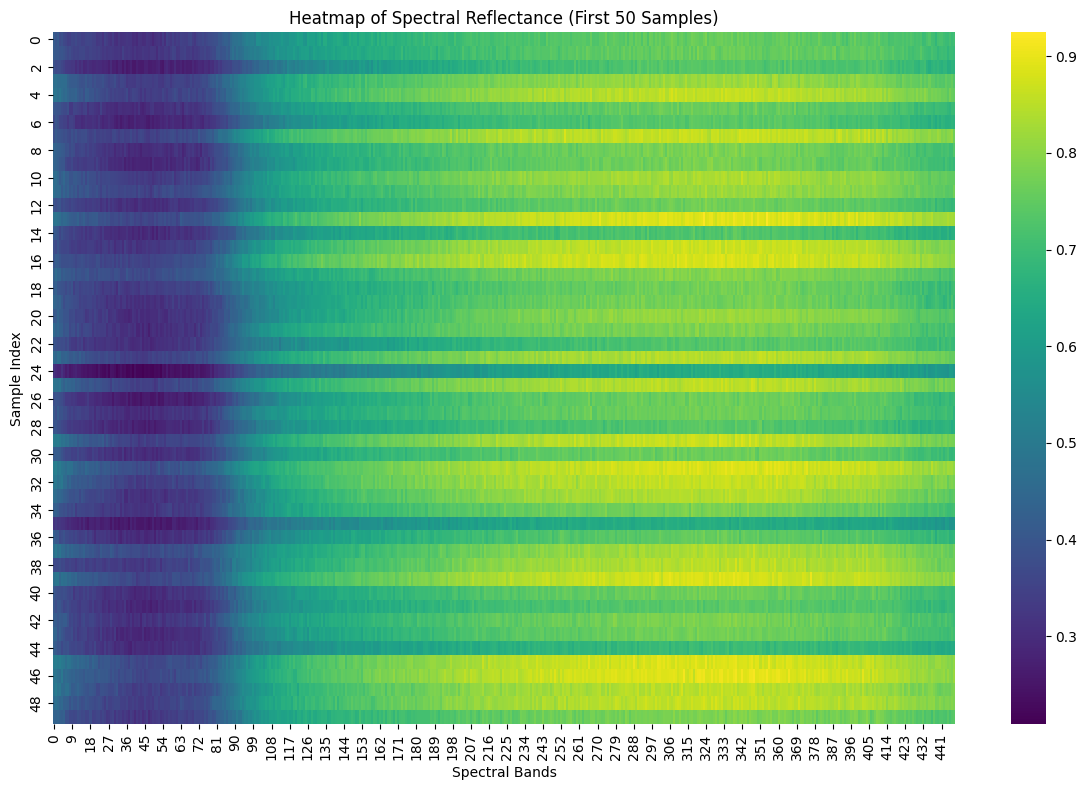

In [4]:
# 1. Data Exploration and Preprocessing
# ------------------------------

# Load the dataset
file_path = '/kaggle/input/cornsamples/TASK-ML-INTERN.csv'
data = pd.read_csv(file_path)

# Check dataset shape and preview the data
print("Dataset shape:", data.shape)
print(data.head())

# Drop the non-numeric column "hsi_id" as it's not needed for modeling
data.drop(columns=['hsi_id'], inplace=True)

# Now check for missing values in the numeric data and fill them
print("\nMissing values in each column:\n", data.isnull().sum())
data.fillna(data.mean(), inplace=True)

# Set the target variable as 'vomitoxin_ppb'
target_col = 'vomitoxin_ppb'
features = data.drop(columns=[target_col])
target = data[target_col]

# Visualize the average spectral reflectance per band
avg_reflectance = features.mean()
plt.figure(figsize=(12, 6))
plt.plot(avg_reflectance.index, avg_reflectance.values, marker='o')
plt.title('Average Spectral Reflectance per Band')
plt.xlabel('Spectral Band')
plt.ylabel('Average Reflectance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Heatmap of the spectral values for the first 50 samples
plt.figure(figsize=(12, 8))
sns.heatmap(features.iloc[:50], cmap='viridis')
plt.title('Heatmap of Spectral Reflectance (First 50 Samples)')
plt.xlabel('Spectral Bands')
plt.ylabel('Sample Index')
plt.tight_layout()
plt.show()

# Standardize the spectral features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


Number of PCA components to retain 95% variance: 3


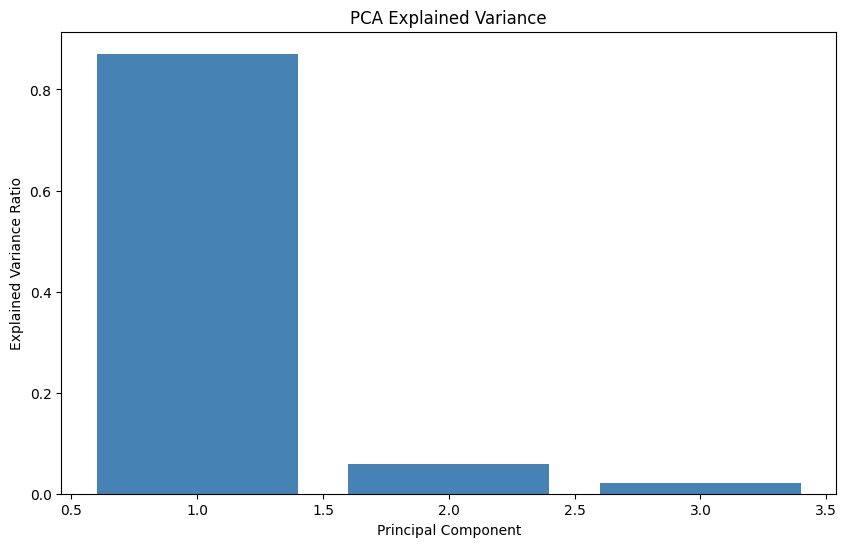

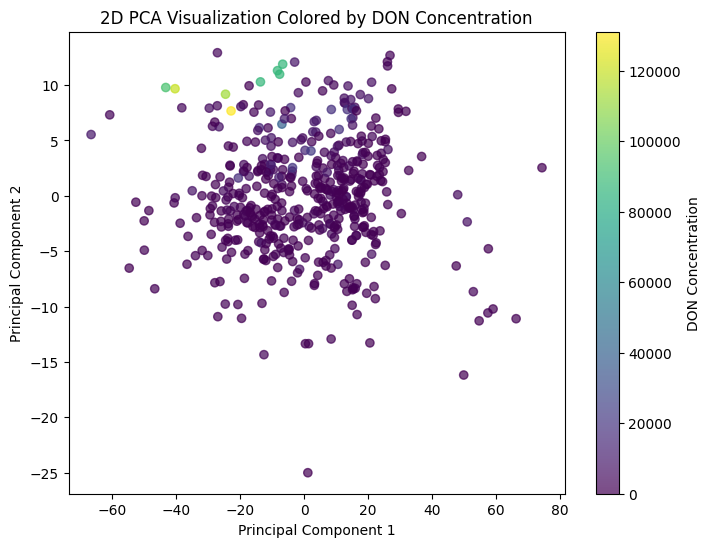

In [5]:
# 2. Dimensionality Reduction using PCA
# ------------------------------

# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
features_pca = pca.fit_transform(features_scaled)
print("\nNumber of PCA components to retain 95% variance:", pca.n_components_)

# Plot explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, color='steelblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.show()

# For visualization purposes, reduce to 2 components
pca_2d = PCA(n_components=2)
features_pca_2d = pca_2d.fit_transform(features_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(features_pca_2d[:, 0], features_pca_2d[:, 1], c=target, cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Visualization Colored by DON Concentration')
plt.colorbar(label='DON Concentration')
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 446, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 223, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 223, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 221, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 110, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 110, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7040)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         450,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 459,073 (1.75 MB)

 Trainable params: 459,073 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 101503392.0000 - mae: 2707.1536 - val_loss: 202943456.0000 - val_mae: 4068.0391
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 101161144.0000 - mae: 2670.5896 - val_loss: 201971184.0000 - val_mae: 4002.6890
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 100196992.0000 - mae: 2598.1685 - val_loss: 199407872.0000 - val_mae: 3937.1626
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 98210344.0000 - mae: 2602.8225 - val_loss: 194917600.0000 - val_mae: 4031.6343
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 96003512.0000 - mae: 2960.1855 - val_loss: 190867472.0000 - val_mae: 4283.6089
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 94924880.0000 - mae: 3419.4629 - val_loss: 188681056.0000 - val_mae: 4352.8193
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 94494768.0000 - mae: 3615.2637 - val_loss: 187687568.0000 - val_mae: 4367.7378
Epoch 8/100
10/10 ━━━━━━

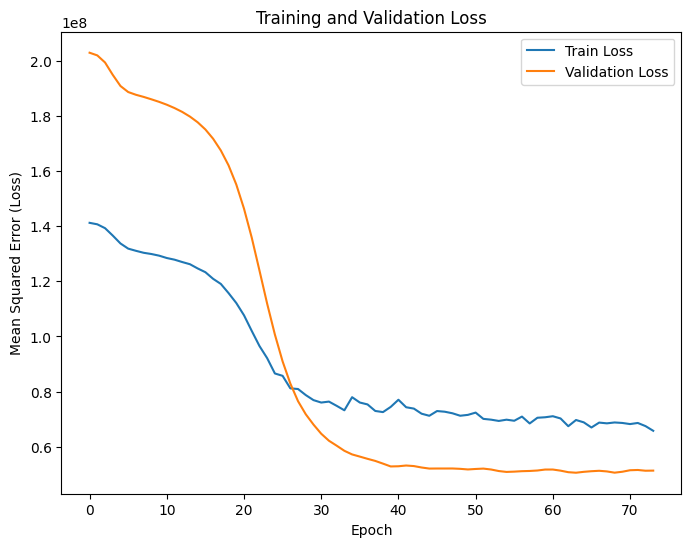

In [6]:
# 3. Model Training Using a CNN for Regression
# ------------------------------

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# For a 1D CNN, reshape the data to add a channel dimension: (samples, features, 1)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the CNN model
def build_cnn_model(input_shape):
    model = Sequential([
        # First convolutional block
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        # Second convolutional block
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        # Flatten and add dense layers for regression
        Flatten(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Define the input shape for the CNN
input_shape = (X_train_cnn.shape[1], 1)
cnn_model = build_cnn_model(input_shape)
cnn_model.summary()

# Train the model using early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = cnn_model.fit(X_train_cnn, y_train,
                        validation_split=0.2,
                        epochs=100,
                        batch_size=32,
                        callbacks=[early_stop],
                        verbose=1)

# Plot training and validation loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (Loss)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Evaluation Metrics:
Mean Absolute Error (MAE): 3170.003761434555
Root Mean Squared Error (RMSE): 9138.952689336218
R² Score: 0.7012144451812201


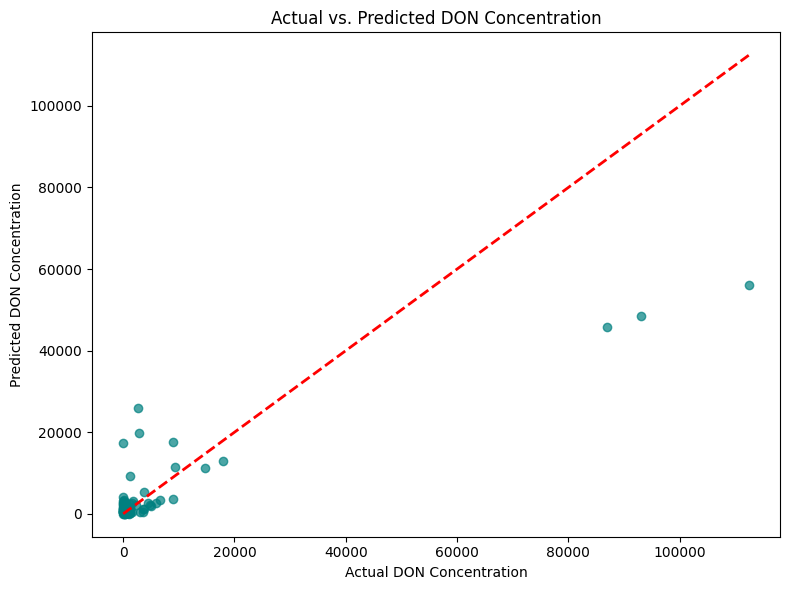

The neural network achieved an MAE of 3170.004, RMSE of 9138.953, and R² of 0.701 on the test set.


In [7]:
# 4. Model Evaluation
# ------------------------------

# Predict on the test set
y_pred = cnn_model.predict(X_test_cnn).flatten()

# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nEvaluation Metrics:")
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

# Scatter plot: Actual vs. Predicted DON Concentration
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual DON Concentration')
plt.ylabel('Predicted DON Concentration')
plt.title('Actual vs. Predicted DON Concentration')
plt.tight_layout()
plt.show()

# Summary of model performance
print("The neural network achieved an MAE of {:.3f}, RMSE of {:.3f}, and R² of {:.3f} on the test set.".format(mae, rmse, r2))